In [1]:
#Load Libraries
from __future__ import division,print_function

%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from tqdm import tqdm_notebook as tqdm

import random
import matplotlib.pyplot as plt
import math

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable, grad
from torchvision import datasets, transforms
from torch.nn.parameter import Parameter

import torch.optim as optim
from torch.optim import lr_scheduler

from collections import Counter

import calculate_log as callog


import torchvision

import time
import warnings
import os
import copy
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [36]:
# Data augmentation and normalization for training
# Just normalization for validation
std = np.array([[0.2023, 0.1994, 0.2010]]).T
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
batch_size=128*10
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize


    ]),
    'val': transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize


    ]),
    'test': transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize

    ]),

}

In [37]:
#Loading datasets
data_dir = '03_sen12ms/conversion_result/id-data/' #change the dataset location
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), #3 inctances(train,test and validation)
                                          data_transforms[x])
                  for x in ['train', 'val','test']} #if it's train, check the data_dir folder, then go to train folder, transform all the image according to data_transform. do the same for test and validation
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True)
              for x in ['train', 'val', 'test']} #put all the datasets into  dataloader to make tensors
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

### Check the datsets size

In [38]:
print(dataset_sizes['train'])
print(dataset_sizes['val'])
print(dataset_sizes['test'])
print(class_names)

120971
15129
15213
['fall', 'spring', 'summer']


### Showing a batch of images with class labels

to show number of images, change the batch size accordingly to the previous cell.

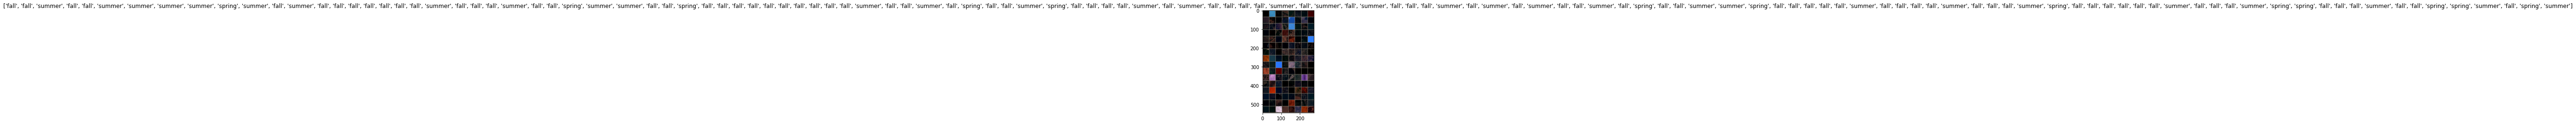

In [39]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
  
    inp = np.clip(inp, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Defining the model architecture

In [40]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
    
    def forward(self, x):
        t = self.conv1(x)
        out = F.relu(self.bn1(t))
        torch_model.record(t)
        torch_model.record(out)
        t = self.conv2(out)
        out = self.bn2(self.conv2(out))
        torch_model.record(t)
        torch_model.record(out)
        t = self.shortcut(x)
        out += t
        torch_model.record(t)
        out = F.relu(out)
        torch_model.record(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes = 3):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        
        self.collecting = False
    
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        y = self.linear(out)
        return y
    def record(self, t):
        if self.collecting:
            self.gram_feats.append(t)
torch_model = ResNet(BasicBlock, [3,4,6,3])

In [41]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [42]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [43]:
model_ft = torch_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [44]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 0.7062 Acc: 0.6581
val Loss: 0.6729 Acc: 0.6807

Epoch 1/99
----------
train Loss: 0.6598 Acc: 0.6819
val Loss: 0.7131 Acc: 0.6590

Epoch 2/99
----------
train Loss: 0.6427 Acc: 0.6908
val Loss: 0.7049 Acc: 0.6632

Epoch 3/99
----------
train Loss: 0.6312 Acc: 0.6975
val Loss: 0.6837 Acc: 0.6786

Epoch 4/99
----------
train Loss: 0.6199 Acc: 0.7034
val Loss: 0.6873 Acc: 0.6830

Epoch 5/99
----------
train Loss: 0.6124 Acc: 0.7088
val Loss: 0.6233 Acc: 0.7144

Epoch 6/99
----------
train Loss: 0.6061 Acc: 0.7124
val Loss: 0.7052 Acc: 0.6759

Epoch 7/99
----------
train Loss: 0.5734 Acc: 0.7316
val Loss: 0.5691 Acc: 0.7359

Epoch 8/99
----------
train Loss: 0.5639 Acc: 0.7368
val Loss: 0.5634 Acc: 0.7385

Epoch 9/99
----------
train Loss: 0.5604 Acc: 0.7397
val Loss: 0.6028 Acc: 0.7231

Epoch 10/99
----------
train Loss: 0.5591 Acc: 0.7405
val Loss: 0.5710 Acc: 0.7254

Epoch 11/99
----------
train Loss: 0.5548 Acc: 0.7442
val Loss: 0.5483 Acc: 0.7468

Ep

### Save the model

In [45]:
PATH = './resne50_sen12ms.pth'
torch.save(torch_model.state_dict(),PATH)

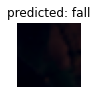

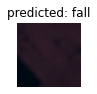

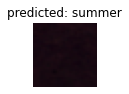

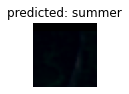

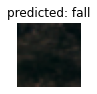

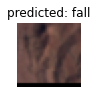

In [46]:
visualize_model(torch_model)